This notebook is for cell cycle related analysis, which includes     
1. cell cycle identification via both gene expression and fluorescence    
2. comparison between STARmap and RIBOmap 

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from spatial_funcs import *
from scipy.stats import *
from skimage.measure import regionprops

# Input

In [2]:
fpath = 'Z:/Data/Analyzed/2022-02-02-Hu-Hela_FUCCI'
rpath = 'Z:/Connie/RIBOmap/result/FUCCI data'
adata = sc.read_h5ad(rpath+'/adata/FUCCI_cell_&_gene_filter_02-15-22.h5ad')
genes = adata.var.index
sample_list = ['RIBOmap', 'STARmap']

# Cell cycle identification

## marker gene expression 

In [3]:
# Load markers 
base_path = 'Z:/Connie/RIBOmap'
s_genes = pd.read_excel(os.path.join(base_path, 'gene_modules/cell_cycle_markers.xlsx'), sheet_name='G1_S', header=None)[0].to_list()
g2m_genes = pd.read_excel(os.path.join(base_path, 'gene_modules/cell_cycle_markers.xlsx'), sheet_name='G2_M', header=None)[0].to_list()
cell_cycle_genes = s_genes + g2m_genes

In [4]:
# Get cell cycle genes 
missed_genes = [x for x in cell_cycle_genes if x not in adata.var_names]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes_true = [x for x in s_genes if x in adata.var_names]
g2m_genes_true = [x for x in g2m_genes if x in adata.var_names]

print('cell cycle genes: ', len(cell_cycle_genes), '\nmissed genes: ', len(missed_genes))
print(f"G1/S genes: {len(s_genes)} - G2/M genes: {len(g2m_genes)}")
print(f"G1/S genes in our dataest: {len(s_genes_true)} - G2/M genes in our dataest: {len(g2m_genes_true)}")

cell cycle genes:  41 
missed genes:  0
G1/S genes: 19 - G2/M genes: 22
G1/S genes in our dataest: 19 - G2/M genes in our dataest: 22


In [5]:
adata_ribo = separate_adata_by_sample(adata, 'RIBOmap')
adata_star = separate_adata_by_sample(adata, 'STARmap')

### RIBOmap

In [6]:
sc.pp.normalize_total(adata_ribo)
sc.pp.log1p(adata_ribo)
sc.pp.scale(adata_ribo)

C:\Users\wangk\.conda\envs\connie\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
C:\Users\wangk\.conda\envs\connie\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


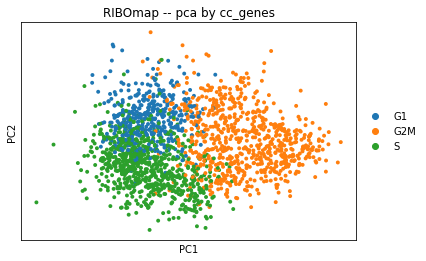

In [7]:
# Compute gene set score
sc.tl.score_genes_cell_cycle(adata_ribo, s_genes=s_genes_true, g2m_genes=g2m_genes_true)
adata_ribo_cc_genes = adata_ribo[:, cell_cycle_genes]
sc.tl.pca(adata_ribo_cc_genes)
sc.pl.pca_scatter(adata_ribo_cc_genes, color='phase', title='RIBOmap -- pca by cc_genes')

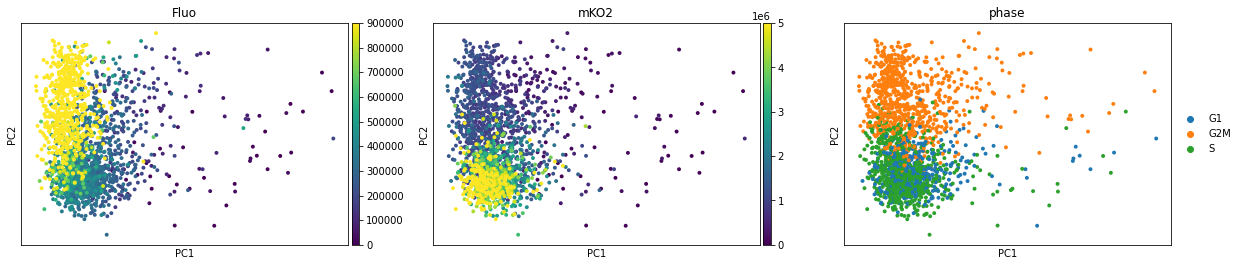

In [8]:
sc.tl.pca(adata_ribo)
sc.pl.pca(adata_ribo, color=['Fluo', 'mKO2', 'phase'], vmax=[0.9*1e6, 0.5*1e7])

In [9]:
adata_ribo.obs.loc[:, 'phase_new'] = adata_ribo.obs['phase'].values
# adata.write_h5ad(rpath+'/adata/FUCCI_ribomap_cc_02-22-22.h5ad')

### STARmap

In [10]:
sc.pp.normalize_total(adata_star)
sc.pp.log1p(adata_star)
sc.pp.scale(adata_star)

C:\Users\wangk\.conda\envs\connie\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
C:\Users\wangk\.conda\envs\connie\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


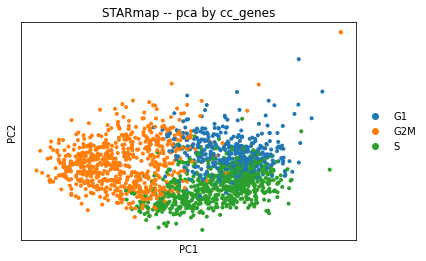

In [11]:
# Compute gene set score
sc.tl.score_genes_cell_cycle(adata_star, s_genes=s_genes_true, g2m_genes=g2m_genes_true)
adata_star_cc_genes = adata_star[:, cell_cycle_genes]
sc.tl.pca(adata_star_cc_genes)
sc.pl.pca_scatter(adata_star_cc_genes, color='phase', title='STARmap -- pca by cc_genes')

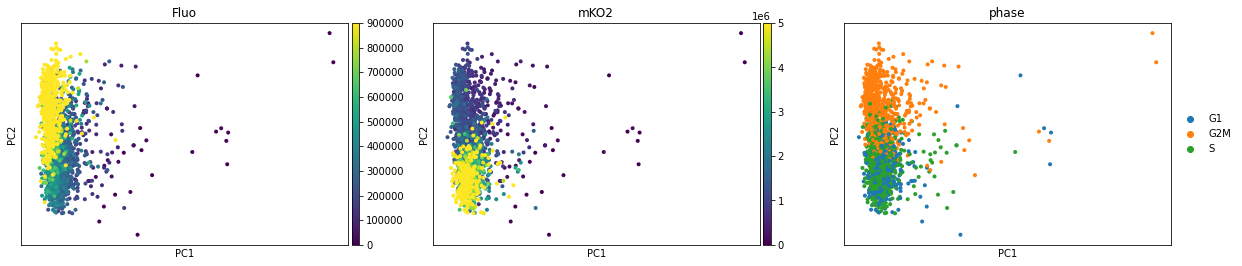

In [12]:
sc.tl.pca(adata_star)
sc.pl.pca(adata_star, color=['Fluo', 'mKO2', 'phase'], vmax=[0.9*1e6, 0.5*1e7])

In [13]:
adata_star.obs.loc[:, 'phase_new'] = adata_star.obs['phase'].values
# adata.write_h5ad(rpath+'/adata/FUCCI_starmap_cc_02-22-22.h5ad')

In [ ]:
# adata.write_h5ad(rpath+'/adata/FUCCI_cc_02-22-22.h5ad')

## FUCCI fluorescence

In [14]:
adata = sc.read_h5ad(rpath+'/adata/FUCCI_cc_02-22-22.h5ad')

Text(0.5, 1.0, 'fluoresence after filtering')

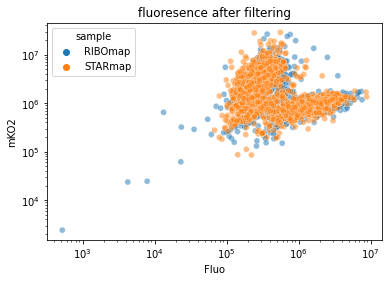

In [15]:
# after filtering
fig = sns.scatterplot(data=adata.obs[adata.obs['pass_all_filters']], x='Fluo', y='mKO2', hue='sample', alpha=0.5)
fig.set_xscale('log'), fig.set_yscale('log')
fig.set_title('fluoresence after filtering')

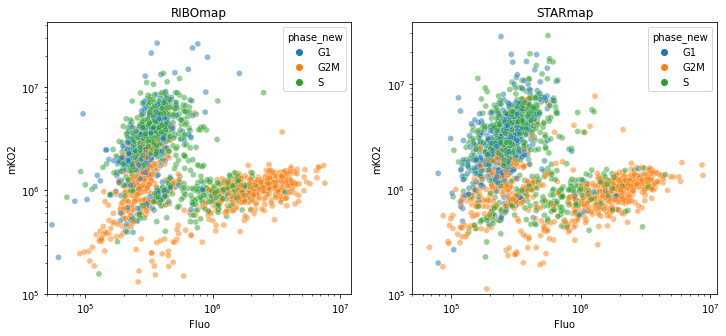

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
for i, s in enumerate(sample_list):
    sns.scatterplot(data=adata.obs[np.logical_and(adata.obs['pass_all_filters'], adata.obs['sample']==s)], x='Fluo', y='mKO2', hue='phase_new', alpha=0.5, ax=ax[i])
    ax[i].set_xscale('log'), ax[i].set_yscale('log')
    ax[i].set_xlim(5*1e4), ax[i].set_ylim(1e5)
    ax[i].set_title(s)

### normalization

In [3]:
sample = 'starmap'
adata = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_02-22-22.h5ad'.format(sample))

In [4]:
# cytosol intensity -- substract or not 
nuclei = tifffile.imread(os.path.join(fpath, 'segmentation', sample, 'nuclei.tif'))
rp_nuclei = regionprops(nuclei)

100%|██████████| 1859/1859 [00:05<00:00, 340.85it/s]


<AxesSubplot:xlabel='nuclei_vol', ylabel='Count'>

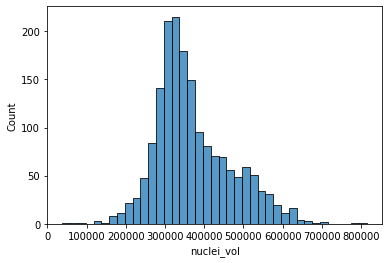

In [5]:
nuclei_vol = []
for r in tqdm(rp_nuclei):
    nuclei_vol.append(r.area)
adata.obs['nuclei_vol'] = nuclei_vol
sns.histplot(adata[adata.obs['pass_all_filters']].obs['nuclei_vol'])

In [6]:
# normalize by volume
adata.obs['mAG_norm'] = adata.obs['Fluo'] / adata.obs['nuclei_vol']
adata.obs['mKO2_norm'] = adata.obs['mKO2'] / adata.obs['nuclei_vol']

In [7]:
# z score
adata.obs['mAG_norm_zscore'] = zscore(adata.obs['mAG_norm'])
adata.obs['mKO2_norm_zscore'] = zscore(adata.obs['mKO2_norm'])

In [8]:
adata.write_h5ad(rpath+'/adata/{}_fucci_norm_03-07.h5ad'.format(sample))

# Diffusion map embedding

In [10]:
sample = 'starmap' # pseudotime constructed based on STARmap
adata = sc.read_h5ad(rpath+'/adata/{}_fucci_norm_03-07.h5ad'.format(sample))

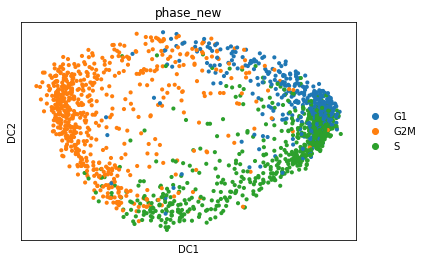

In [11]:
# diffusion map constructed from cell cycle expression
adata_cc = adata[adata.obs['pass_all_filters'], cell_cycle_genes]
sc.pp.neighbors(adata_cc, n_neighbors=30, method='umap', knn=True, metric='cosine') 
sc.tl.diffmap(adata_cc, n_comps=4) 
sc.pl.diffmap(adata_cc, color=['phase_new'], cmap='Spectral')

In [ ]:
# fig = sc.pl.diffmap(adata_cc, color='phase_new', palette=['#F781BF', '#00BFC4', '#FA4B0E'], return_fig=True)
# fig.savefig(rpath+'/figures/cell_cycle/starmap_cc2.pdf')

In [10]:
adataSTAR_with_meta = copy(adata)

In [9]:
def align(value_vec, filter_vec):
    '''return a vec same length as filter_vec with value_vec's value'''
    res = []
    p = 0
    for i in filter_vec:
        if i:
            res.append(value_vec[p])
            p += 1
        else: res.append('None')
    return res

In [11]:
diffmap_with_filtering = []
p = 0
for i in adataSTAR_with_meta.obs['pass_all_filters']: 
    if i:
        diffmap_with_filtering.append(adata_cc.obsm['X_diffmap'][p, 1:3])
        p += 1
    else: diffmap_with_filtering.append(np.array(['None', 'None']))
adataSTAR_with_meta.obsm['X_diffmap'] = np.array(diffmap_with_filtering)

In [22]:
# pd.DataFrame(adata_cc.obsm['X_diffmap'][:, 1:3]).to_excel(f'{rpath}/temp.xlsx')

### using this manifold

<AxesSubplot:title={'center':'mKO2_norm_zscore'}, xlabel='DC1', ylabel='DC2'>

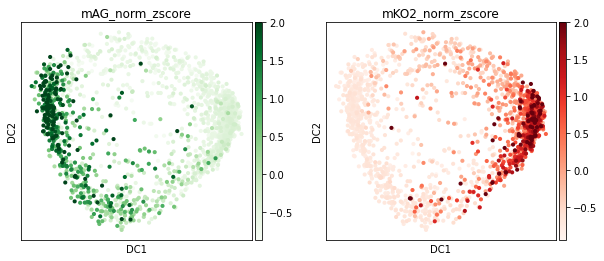

In [12]:
# zscored fluo
fig, ax = plt.subplots(1,2,figsize=(10,4))
sc.pl.diffmap(adata_cc, color='mAG_norm_zscore', components=['1,2'], vmax=2, cmap='Greens', ax=ax[0], show=False)
sc.pl.diffmap(adata_cc, color='mKO2_norm_zscore', components=['1,2'], vmax=2, cmap='Reds', ax=ax[1], show=False)

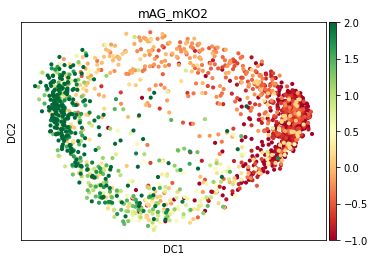

In [13]:
# merge two fluo
mKO2_neg = -adata_cc.obs['mKO2_norm_zscore']
mAG_mKO2 = adata_cc.obs['mAG_norm_zscore'] + mKO2_neg
adata_cc.obs['mAG_mKO2'] = mAG_mKO2
fig = sc.pl.diffmap(adata_cc, color='mAG_mKO2', components=['1,2'], vmin=-1, vmax=2, cmap='RdYlGn', return_fig=True)
# fig.savefig(rpath+'/figures/cell_cycle/fluo_combined_starmap.pdf')

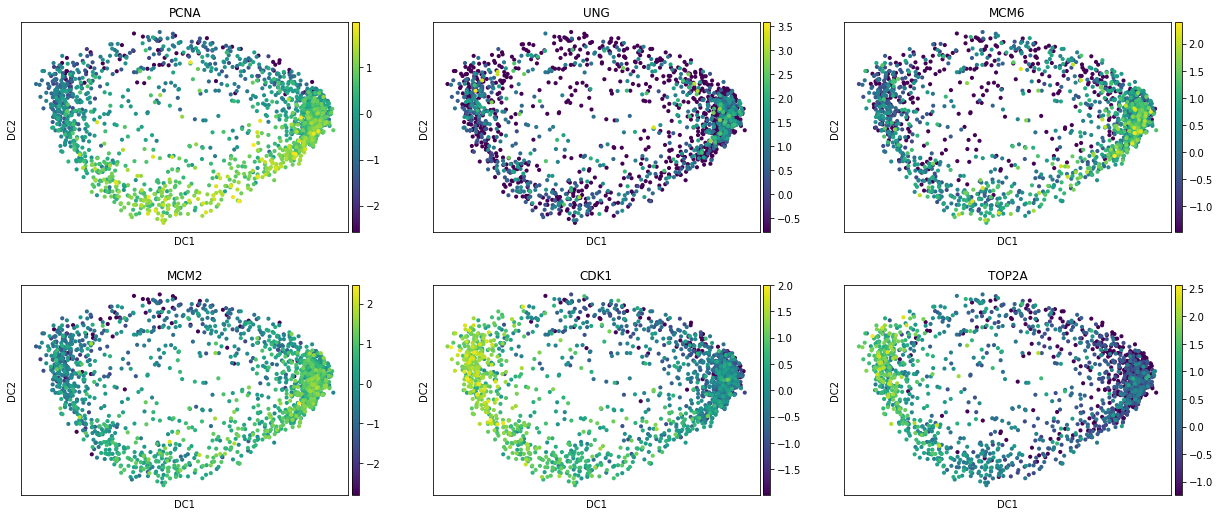

In [14]:
# cc marker gene expression
fig = sc.pl.diffmap(adata_cc, color=['PCNA', 'UNG', 'MCM6', 'MCM2', 'CDK1', 'TOP2A'], 
                components=['1,2'], cmap='viridis', ncols=3,
                show=True, return_fig=True)
# plt.savefig(rpath+'/figures/cell_cycle/marker_expr_starmap.pdf')

In [17]:
sample = 'ribomap'
adata_ribo = sc.read_h5ad(rpath+'/adata/{}_fucci_norm_03-07.h5ad'.format(sample))
adata_ribo_cc = adata_ribo[adata_ribo.obs['pass_all_filters'], cell_cycle_genes]

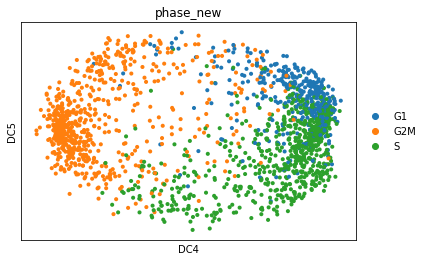

In [18]:
adata_ribo_cc = adata_ribo[adata_ribo.obs['pass_all_filters'], cell_cycle_genes]

sc.pp.neighbors(adata_ribo_cc, n_neighbors=30, method='umap', knn=True, metric='cosine') 
sc.tl.diffmap(adata_ribo_cc, n_comps=4)
# for rotation purposes..
adata_ribo_cc.obsm['X_diffmap'] = np.concatenate((adata_ribo_cc.obsm['X_diffmap'], -adata_ribo_cc.obsm['X_diffmap'][:,1].reshape(-1,1), -adata_ribo_cc.obsm['X_diffmap'][:,3].reshape(-1,1)), axis=1)
fig = sc.pl.diffmap(adata_ribo_cc, color=['phase_new'], components=['4,5'], cmap='Oranges', return_fig=True)
# fig.savefig(rpath+'/figures/cell_cycle/transferred_pt_phase_ribomap.pdf')

In [81]:
# organize for metadata
adataRIBO_with_meta = copy(adata_ribo)

diffmap_with_filtering_ribo = []
p = 0
for i in adataRIBO_with_meta.obs['pass_all_filters']: 
    if i:
        diffmap_with_filtering_ribo.append(adata_ribo_cc.obsm['X_diffmap'][p, 4:])
        p += 1
    else: diffmap_with_filtering_ribo.append(np.array(['None', 'None']))
adataRIBO_with_meta.obsm['X_diffmap'] = np.array(diffmap_with_filtering_ribo)

In [92]:
with pd.ExcelWriter(rpath+'/diffmap.xlsx') as writer:  
    pd.DataFrame(adata_cc.obsm['X_diffmap'][:,:2]).to_excel(writer, sheet_name='STARmap')
    pd.DataFrame(adata_ribo_cc.obsm['X_diffmap'][:,4:]).to_excel(writer, sheet_name='RIBOmap')

In [103]:
m6A_labels = pd.read_excel('Z:/Connie/RIBOmap/gene_modules/m6A new label.xlsx')
m6A_RIBO = [m6A_labels[m6A_labels['Gene']==g]['m6A label'].values[0] for g in adataSTAR_with_meta.var.index]

In [113]:
adataSTAR_with_meta.var['m6A'] = m6A_RIBO
adataRIBO_with_meta.var['m6A'] = m6A_RIBO

In [115]:
dr_STAR = pd.read_excel(f'{rpath}/FUCCI_expr_dr.xlsx', sheet_name='RIBOmap')
dr_RIBO = pd.read_excel(f'{rpath}/FUCCI_expr_dr.xlsx', sheet_name='STARmap')

In [119]:
adataSTAR_with_meta.var['DR'] = dr_STAR.DR.values
adataRIBO_with_meta.var['DR'] = dr_RIBO.DR.values

In [ ]:
adataSTAR_with_meta.write_h5ad(rpath+'/adata/star_meta.h5ad')
adataRIBO_with_meta.write_h5ad(rpath+'/adata/ribo_meta.h5ad')

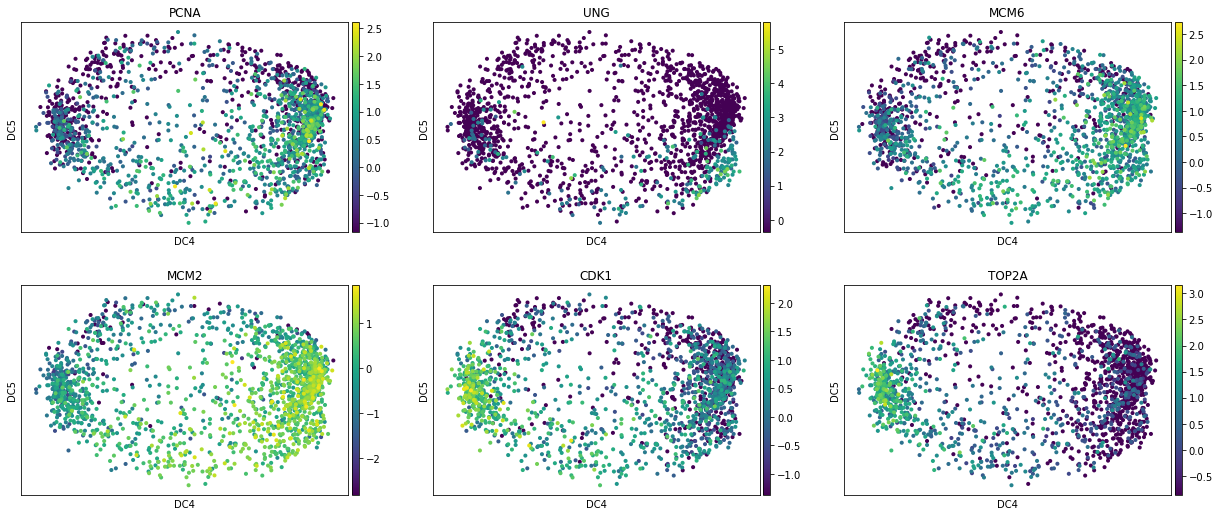

In [70]:
# cc marker gene expression
fig = sc.pl.diffmap(adata_ribo_cc, color=['PCNA', 'UNG', 'MCM6', 'MCM2', 'CDK1', 'TOP2A'], 
                components=['4,5'], cmap='viridis', ncols=3,
                show=True, return_fig=True)
# plt.savefig(rpath+'/figures/cell_cycle/marker_expr_ribomap.pdf')

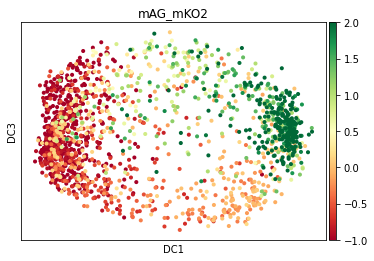

In [53]:
# merge two fluo
mKO2_neg = -adata_ribo_cc.obs['mKO2_norm_zscore']
mAG_mKO2 = adata_ribo_cc.obs['mAG_norm_zscore'] + mKO2_neg
adata_ribo_cc.obs['mAG_mKO2'] = mAG_mKO2
fig = sc.pl.diffmap(adata_ribo_cc, color='mAG_mKO2', components=['1,3'], vmin=-1, vmax=2, cmap='RdYlGn', return_fig=True)
# fig.savefig(rpath+'/figures/cell_cycle/fluo_combined_ribomap.pdf')

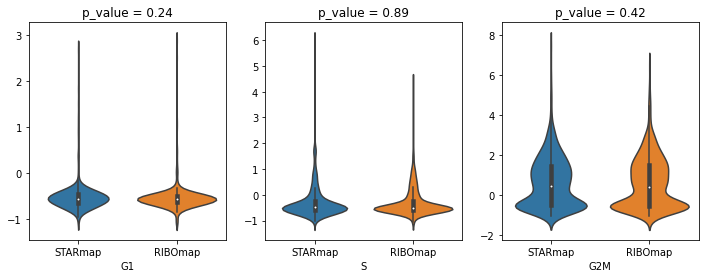

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
for i, phase in enumerate(['G1', 'S', 'G2M']):
    sns.violinplot(data=[adata_star.obs[adata_star.obs['phase_new']==phase]['mAG_norm_zscore'],
                adata_ribo.obs[adata_ribo.obs['phase_new']==phase]['mAG_norm_zscore']], ax=ax[i], element='step').set_xlabel(phase)
    ax[i].set_xticklabels(['STARmap', 'RIBOmap'])
    ax[i].set_title('p_value = {:.2f}'.format(ranksums(adata_star.obs[adata_star.obs['phase_new']==phase]['mAG_norm_zscore'],
                adata_ribo.obs[adata_ribo.obs['phase_new']==phase]['mAG_norm_zscore'])[1]))